# MSc Project : Understanding the data

### Using 2019 Monsoon season (JJAS) - Temp (at 2m) and Precipitaion (TRMM/GPM data) to find a relation b/w ERRs and maximum temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import netCDF4
# import pandas as pd
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
from dask.distributed import Client, Variable
%matplotlib inline

In [2]:
from functions import ccplot, binning

In [3]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")

In [4]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu', cmap_sequential='Blues')

In [5]:
# Getting the data

# client = Client()

mfdataDIR1 = './data/GPM_lowres_data/3B-HHR.MS.MRG.3IMERG.*.V06B.HDF5.nc'

ds1 = xr.open_mfdataset(mfdataDIR1, engine = 'netcdf4', combine = 'nested', concat_dim='time', parallel=True) # this is GPM IMERG data

In [6]:
mfdataDIR2 = './data/temp_data/data2.nc'
ds2 = xr.open_mfdataset(mfdataDIR2, parallel=True) # this is Temp data

In [7]:
# # convert the time array of T2 dataset
# ds2['time'] = xr.cftime_range(start = "2019-06-01 00:00:00", end = "2019-09-30 23:00:00", freq = "H")

In [8]:
# adding proper dates to ds1
# start = datetime(2019, 6, 1, 0, 0)
# end = datetime(2019, 9, 30, 23, 30)
# step = timedelta(minutes=30)

# dates = []

# while start < end:
#     dates.append(start.strftime('%Y-%m-%d %H:%M:%S'))
#     start += step

# ds1['time'] = dates

In [9]:
# # Import the TRMM data

# def add_time_dim(xda):
#     xda = xda.expand_dims(time = [datetime.now()])
#     return xda

# mfdataDIR3 = './data/TRMM_data/3B42.*.HDF.nc4'
# ds3 = xr.open_mfdataset(mfdataDIR3, parallel=True, preprocess=add_time_dim)

In [10]:
# # adding proper dates to ds3
# start = datetime(2019, 6, 1, 0)
# end = datetime(2019, 10, 1, 0)
# step = timedelta(hours=3)

# dates = []

# while start <= end:
#     dates.append(start.strftime('%Y-%m-%d %H:%M:%S'))
#     start += step

# ds3['time'] = dates

In [11]:
ds1 = ds1.drop_dims('bnds')

In [12]:
ds1 = ds1.transpose("time", "lat", "lon")
ds1

<xarray.Dataset>
Dimensions:                         (time: 5855, lon: 181, lat: 141)
Coordinates:
  * time                            (time) datetime64[ns] 2019-06-01 ... 2019...
  * lon                             (lon) float64 50.0 50.25 50.5 ... 94.75 95.0
  * lat                             (lat) float64 5.0 5.25 5.5 ... 39.75 40.0
Data variables:
    precipitationQualityIndex       (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    HQprecipSource                  (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    precipitationCal                (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    precipitationUncal              (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    HQprecipitation                 (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    HQobservationTime               (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    randomError                     (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    IRprecipitation                 (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
Attributes:
    CDI:                             Climate Data Interface version 1.9.10 (h...
    Conventions:                     CF-1.6
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         Tue Sep 14 08:54:14 2021: cdo -L -z zip_...
    CDO:                             Climate Data Operators version 1.9.10 (h...

In [13]:
ds2 = ds2.transpose("time", "latitude", "longitude")
ds2 = ds2.rename_dims({"latitude":"lat", "longitude":"lon"})
ds2 = ds2.rename_vars({"latitude":"lat", "longitude":"lon"})
ds2

<xarray.Dataset>
Dimensions:  (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon      (lon) float32 50.0 50.25 50.5 50.75 51.0 ... 94.25 94.5 94.75 95.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 6.0 5.75 5.5 5.25 5.0
  * time     (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-12 12:11:31 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [14]:
# ds3 = ds3.transpose('time', 'nlat', 'nlon')

In [15]:
# ds3 = ds3.sel(nlat=slice(5,40), nlon=slice(50,95))

In [16]:
# ds3

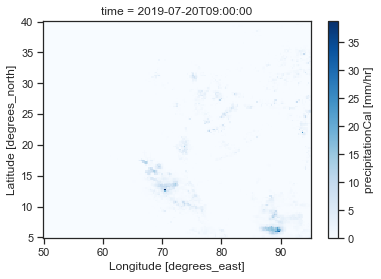

In [17]:
ds1.precipitationCal.sel(time = "2019-07-20 09:00:00").plot()

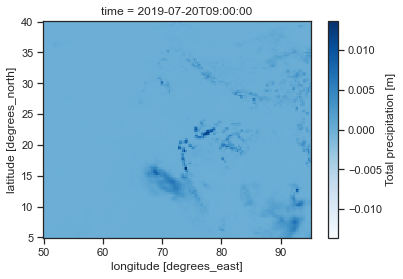

In [18]:
ds2.tp.sel(time = "2019-07-20 09:00:00").plot(cmap = "Blues")

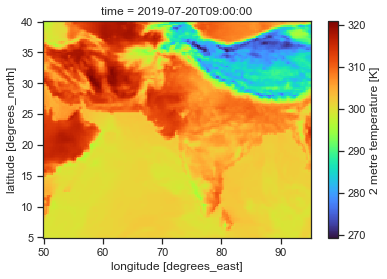

In [19]:
ds2.t2m.sel(time = "2019-07-20 09:00:00").plot(cmap='turbo')

In [20]:
# ds3.precipitation.sel(time = "2019-07-20 09:00:00").plot()

## Data Preparation

**We will use ds1 and ds2. We need to -**

1) coarsen the dimensions of precipitation data ***(DONE)***

2) bin the precipitation and temperature data

3) find a way to visualise the c-c scaling after fitting the exponential function.

In [21]:
# precip30m = ds1.precipitationCal
precip1h = ds1.precipitationCal.resample(time = '1H').mean()
# precip3h = ds1.precipitationCal.resample(time = '3H').mean()
# precip6h = ds1.precipitationCal.resample(time = '6H').mean()
# precip12h = ds1.precipitationCal.resample(time = '12H').mean()
# precip1d = ds1.precipitationCal.resample(time = '1D').mean()

t2m = ds2.t2m
# d2m = ds2.d2m
# u10 = ds2.u10
# v10 = ds2.v10
# tp = ds2.tp
# v = np.sqrt(u10**2 + v10**2)

In [22]:
# precip30m.shape

In [23]:
precip1h.shape

(2928, 141, 181)

In [24]:
t2m.shape

(2928, 141, 181)

In [25]:
# Set values less than 5 mm/hr to nan

precip1h = xr.where(precip1h < 5, np.nan, precip1h)
t2m = t2m.where(precip1h != np.nan)

### Data binning

In [26]:
ds_comb = xr.merge([precip1h, t2m]).chunk(dict(time=-1))

In [27]:
ds_comb

<xarray.Dataset>
Dimensions:           (time: 2928, lon: 181, lat: 141)
Coordinates:
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
  * lon               (lon) float64 50.0 50.25 50.5 50.75 ... 94.5 94.75 95.0
  * lat               (lat) float64 5.0 5.25 5.5 5.75 ... 39.25 39.5 39.75 40.0
Data variables:
    precipitationCal  (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    t2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>

In [28]:
mum = ds_comb.sel(lat = 19.5, lon = 72.5)

In [29]:
mum

<xarray.Dataset>
Dimensions:           (time: 2928)
Coordinates:
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
    lon               float64 72.5
    lat               float64 19.5
Data variables:
    precipitationCal  (time) float32 dask.array<chunksize=(2928,), meta=np.ndarray>
    t2m               (time) float32 dask.array<chunksize=(2928,), meta=np.ndarray>

In [34]:
# # For the ideal value of C-C plot

# temparr = np.sort(ds_comb.t2m.sel(lat = 19.5, lon = 72.5))

# # TODO
# # repalce the initial values of precipitation with the appropriate 
# # minimum precipitation for that range
# p11 = [4]
# p12 = [14]

# for i in range(0, len(temparr) - 1):
#     p21 = p11[i]*((1 + 0.068)**(temparr[i+1] - temparr[i]))
#     p22 = p12[i]*((1 + 0.068)**(temparr[i+1] - temparr[i]))
#     p11.append(p21)
#     p12.append(p22)

# preciparr1 = np.array(p11)
# preciparr2 = np.array(p12)

In [35]:
# def get_binned(ds, lat, lon, percentile_val, bins):
#     return ds.sel(lat = lat, lon = lon).groupby_bins('t2m', bins).quantile(percentile_val, interpolation = 'midpoint')

In [36]:
# precip99 = get_binned(ds_comb, 19.5, 72.5, 0.99, np.arange(270,330,2)).precipitationCal
# precip50 = get_binned(ds_comb, 19.5, 72.5, 0.50, np.arange(270,330,2)).precipitationCal

In [37]:
# # fig = plt.figure(figsize=(14,5))
# fig = plt.figure()
# # plt.subplot(121)
# precip99.plot(marker = 'o', yscale='log', linewidth = 0., color = 'blue')
# plt.semilogy(temparr, preciparr1, 'k--', alpha = 0.4)
# plt.semilogy(temparr, preciparr2, 'k--', alpha = 0.4)
# plt.xlim(ds_comb.t2m.sel(lat = 19.5, lon = 72.5).min(),ds_comb.t2m.sel(lat = 19.5, lon = 72.5).max())
# plt.yticks([1, 10, 100])

# # plt.subplot(122)
# # precip50.plot(marker = 'D', yscale='log', linewidth = 0., color = 'green')
# # plt.semilogy(temparr, preciparr1, 'k--', alpha = 0.4)
# # plt.semilogy(temparr, preciparr2, 'k--', alpha = 0.4)
# # plt.xlim(ds_comb.t2m.sel(lat = 19.5, lon = 72.5).min(),ds_comb.t2m.sel(lat = 19.5, lon = 72.5).max())
# # plt.yticks([1, 10, 100])

# fig.gca().yaxis.set_ticks_position('both')
# fig.tight_layout()

In [38]:
# #define function to calculate equal-frequency bins 

# def equalObs(x, nbin):
#     nlen = len(x)
#     return np.interp(np.linspace(0, nlen, nbin + 1),
#                      np.arange(nlen),
#                      np.sort(x))

# #create histogram with equal-frequency bins 
# n, bins, patches = plt.hist(ds_comb.t2m.sel(lat = 19.5, lon = 72.5), equalObs(ds_comb.t2m.sel(lat = 19.5, lon = 72.5), 12), edgecolor='black')

/home/aditya/.miniconda/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


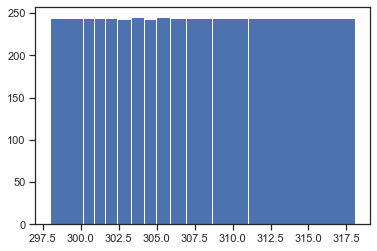

/home/aditya/.miniconda/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


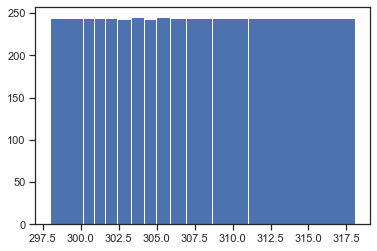

In [30]:
binned_ds99 = binning.get_binned(mum, percentile_val=0.99)
binned_ds50 = binning.get_binned(mum, percentile_val=0.50)

In [33]:
binned_ds99

<xarray.Dataset>
Dimensions:           (t2m_bins: 12)
Coordinates:
  * t2m_bins          (t2m_bins) object (297.99, 300.133] ... (311.031, 318.043]
    quantile          float64 0.99
Data variables:
    precipitationCal  (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    t2m               (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [37]:
binned_ds50

<xarray.Dataset>
Dimensions:           (t2m_bins: 12)
Coordinates:
  * t2m_bins          (t2m_bins) object (297.99, 300.133] ... (311.031, 318.043]
    quantile          float64 0.5
Data variables:
    precipitationCal  (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    t2m               (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [34]:
temparr, preciparr1, preciparr2 = ccplot.get_ideal_data(mum.t2m, 1, 10)

/home/aditya/.miniconda/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/home/aditya/.miniconda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/home/aditya/.miniconda/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/aditya/.miniconda/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/aditya/.miniconda/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/aditya/.miniconda/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/aditya/.miniconda/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, o

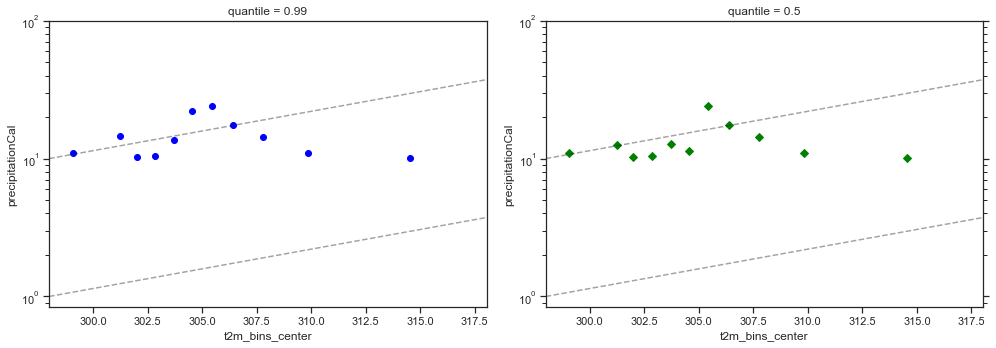

In [36]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds99, temparr, preciparr1, preciparr2, marker = 'o', yscale = 'log', lw = 0., color = 'blue')
plt.subplot(122)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds50, temparr, preciparr1, preciparr2, marker = 'D', yscale = 'log', lw = 0., color = 'green')

fig.gca().yaxis.set_ticks_position('both')
fig.tight_layout()